In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [2]:
%store -r df_cleaned

In [3]:
df_cleaned

,week,wPreis,Plz,full,date
date,,,,,
2020-09-14,2020-37,-37.519318,"['25', '24']",A2 - geschreddert,2020-09-14
2020-09-14,2020-37,-37.519318,"['25', '24']",A1 & A2 - geschreddert,2020-09-14
2020-09-14,2020-37,-23.445068,"['80', '81', '82', '83', '84', '85', '93', '94']",A3 - geschreddert,2020-09-14
2020-09-14,2020-37,-36.379163,"['70', '71', '73', '74', '75', '76']",A2 & A3 - geschreddert,2020-09-14
2020-09-14,2020-37,-27.983877,"['25', '24']",A2 & A3 - geschreddert,2020-09-14
...,...,...,...,...,...
2024-04-22,2024-17,7.216049,"['50', '51', '52', '53']",A2 & A3 - geschreddert,2024-04-22
2024-04-22,2024-17,33.349057,"['70', '71', '73', '74', '75', '76']",A2 & A3 - geschreddert,2024-04-22
2024-04-22,2024-17,2.409250,"['25', '24']",A2 - geschreddert,2024-04-22


In [4]:
df = df_cleaned  

Extracting one cluster from the dataset for analysis.

In [5]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [6]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']
datasets = [TS1_A2, TS1_A1A2, TS1_A2A3]

# Modelling - Train, test split

In [7]:
len(TS1_A1A2)

187

In [8]:
splitratio = 0.05
nobs = round(len(TS1_A1A2)*splitratio)
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

## ARIMA Model


### Static forecast using ARIMA


No retraining. We just use the best ARIMA model to forecast for the test set and evaluate.
We use the once-trained best ARIMA model to forecast for the 6 "steps" in one go. 

In [9]:
model = ARIMA(df_train['wPreis'], order=(4, 1, 0))
static_ARIMA = model.fit()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [10]:
static_ARIMA.forecast(steps=nobs) 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


178    18.125910
179    18.298911
180    19.093380
181    19.087633
182    18.861603
183    19.015715
184    19.131210
185    19.066905
186    19.046352
Name: predicted_mean, dtype: float64

The ARIMA forecast function does not require an "input" other than the steps, so either
- we can do a static forecast (train once on the entire training dataset) and test the predictions for the required steps to compare with the test dataset or
- train in a walk-forward validation where we retrain the model with every step of the test dataset on the new training set which includes the new observation

In [11]:
fc = static_ARIMA.forecast(steps=nobs) 
a = np.array(fc)
df_forecast = pd.DataFrame(a, index=df_test.index[-nobs:], columns=['Predicted_wPreis'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


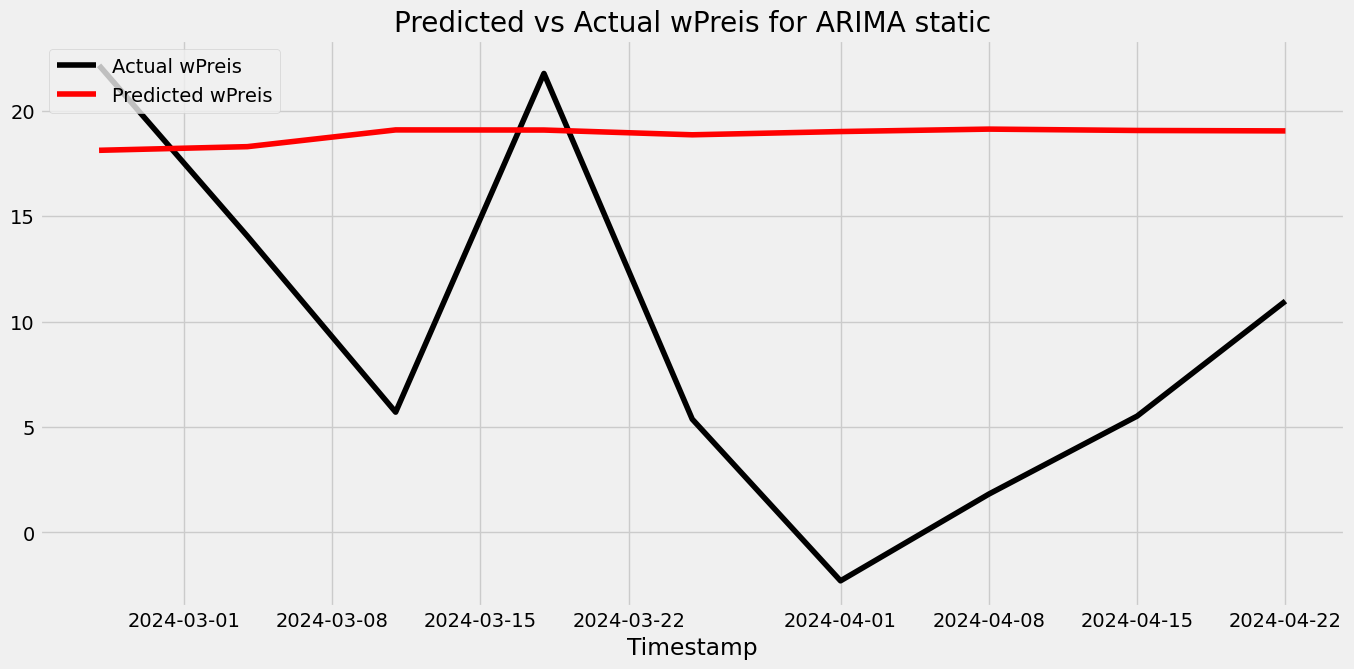

In [12]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 7))
plt.plot(df_test["wPreis"], color='black', label='Actual wPreis')
plt.plot(df_forecast, color='red', label='Predicted wPreis')
plt.xlabel("Timestamp")
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Predicted vs Actual wPreis for ARIMA static')
plt.show()

We will define a forecast accuracyy function that will calculate the mean error, RMSE and also the direction accuracy. 

In [13]:
def forecast_accuracy(forecast, actual):
      mae = mean_absolute_error(actual, forecast)
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae':mae, 'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [14]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('ARIMA static forecast Accuracy of: wPreis')
stat_accuracy_prod = forecast_accuracy(df_forecast['Predicted_wPreis'].values, df_test['wPreis'])
for k, v in stat_accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

ARIMA static forecast Accuracy of: wPreis
mae    :  10.8988
me     :  9.4068
rmse   :  12.4971
direction_accuracy :  0.25


# Walk forward validation using ARIMA model

Training the whole model at each iteration including the new observation (for the next day)  

In [15]:
history = [x for x in df_train['wPreis'].values]  
expect=[]

In [16]:
predictions = list()
for t in range(len(df_test)): # iterate over length of test dataset
    model = ARIMA(history, order=(4,1,0))  
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = df_test['wPreis'][t]
    history.append(obs) # append the real observation at each loop
    expect.append(obs)


In [17]:
df_wPreis = pd.DataFrame(
    {'observations': expect,
     'forecast': predictions, 
    })


In [18]:
def adjust(val, length= 10): return str(val).ljust(length) # 10
print('Walk-forward Validation Forecast Accuracy of wPreis')
wf_accuracy_prod = forecast_accuracy(df_wPreis['forecast'].values, df_wPreis['observations'].values)
for k, v in wf_accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Walk-forward Validation Forecast Accuracy of wPreis
mae        :  7.887
me         :  1.1787
rmse       :  8.9933
direction_accuracy :  0.375


Here, the me and rmse has improved but the direction_accuracy has decreased even further!

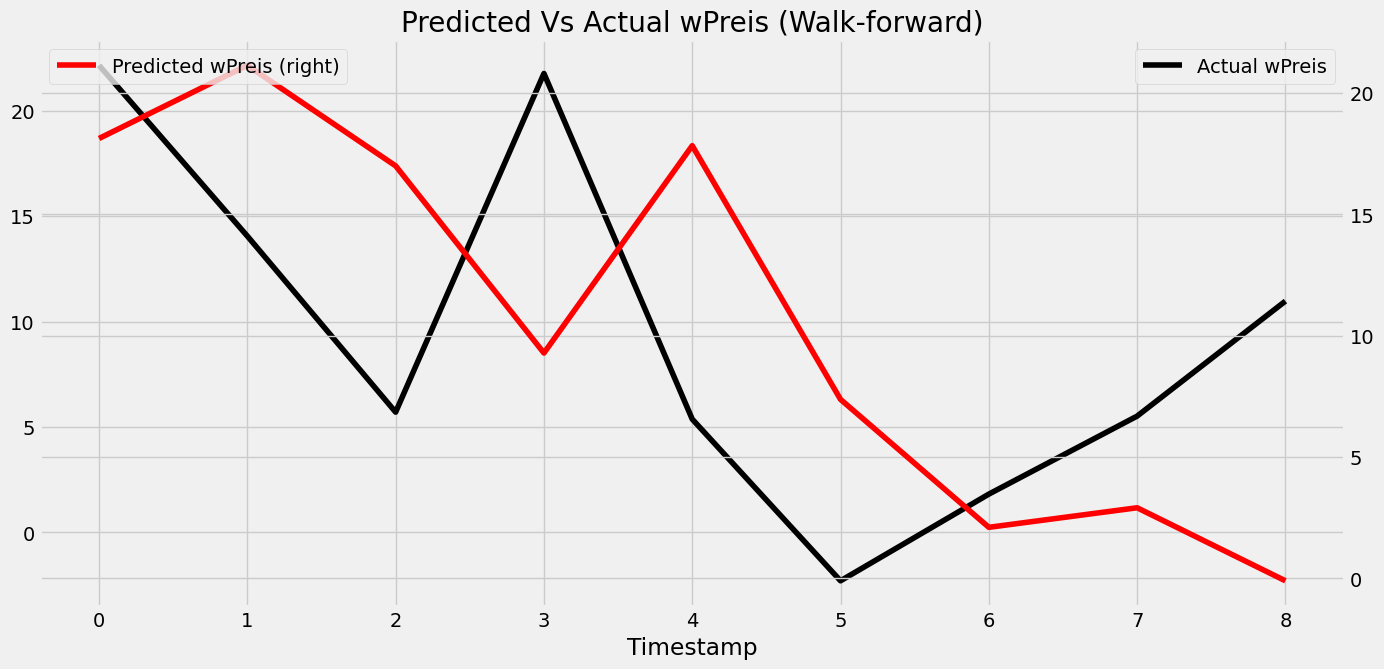

In [19]:
plt.figure(figsize= (15,7))
plt.xlabel("Timestamp")

ax1 = df_wPreis.observations.plot(color = 'black', grid = True, label = 'Actual wPreis')
ax2 = df_wPreis.forecast.plot(color = 'red', grid = True, secondary_y = True, label = 'Predicted wPreis')

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Predicted Vs Actual wPreis (Walk-forward)')
plt.show()

In [20]:
ARIMA_static = pd.DataFrame([stat_accuracy_prod])
ARIMA_walk_forward = pd.DataFrame([wf_accuracy_prod])

In [21]:
%store ARIMA_static
%store ARIMA_walk_forward


Stored 'ARIMA_static' (DataFrame)
Stored 'ARIMA_walk_forward' (DataFrame)


## All other clusters and categories

In [22]:
def forecast_accuracy(forecast, actual):
    mae = mean_absolute_error(actual, forecast)
    me = np.mean(forecast - actual)             # ME
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    # Direction accuracy
    forecast_diff = np.diff(forecast)
    actual_diff = np.diff(actual)
    direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))

    return {'mae':mae, 'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}

In [23]:
# For each dataset data
def static_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]

    # Static forecast
    model = ARIMA(df_train['wPreis'], order=(4, 1, 0))
    static_ARIMA = model.fit()
    static_ARIMA.forecast(steps=nobs) 
    fc = static_ARIMA.forecast(steps=nobs) 
    a = np.array(fc)
    df_forecast = pd.DataFrame(a, index=df_test.index[-nobs:], columns=['Predicted_wPreis'])

    # def adjust(val, length= 6): return str(val).ljust(length) # length
    # print(f'ARIMA static forecast Accuracy of: wPreis in {cluster} for {category}')
    return forecast_accuracy(df_forecast['Predicted_wPreis'].values, df_test['wPreis'])
    # for k, v in stat_accuracy_prod.items():
    #     print(adjust(k), ': ', round(v,4))




In [24]:
def wf_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]
    
    history = [x for x in df_train['wPreis'].values] # "list comprehensions". 
    expect=[]

    predictions = list()
    for t in range(len(df_test)): #  
        model = ARIMA(history, order=(4,1,0))  
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = df_test['wPreis'][t]
        history.append(obs) # appends the real observation at each loop! 
        expect.append(obs)

    df_wPreis = pd.DataFrame(
    {'observations': expect,
     'forecast': predictions, 
    })

    # def adjust(val, length= 10): return str(val).ljust(length) # 10
    # print(f'Walk-forward Validation Forecast Accuracy of wPreis in {cluster} for {category}')
    return forecast_accuracy(df_wPreis['forecast'].values, df_wPreis['observations'].values)
    # for k, v in wf_accuracy_prod.items():
    #     print(adjust(k), ': ', round(v,4))


    
 


In [25]:
clusters = df['Plz'].unique() 
datasets = []
for cluster in clusters:
    ds = df[(df['Plz'] == cluster)]
    categories = ds['full'].unique()
    for category in categories:
        datasets.append(ds[ds['full'] == category])





In [26]:
len(datasets)

33

In [27]:
for dataset in datasets:
    print(dataset.columns)


Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 'Plz', 'full', 'date'], dtype='object')
Index(['week', 'wPreis', 

In [28]:
import warnings

# Filter out the specific warning
warnings.filterwarnings('ignore') #, message="A date index has been provided, but it has no associated frequency information")

In [29]:
# Create an empty list to store dictionaries
data = []

# Loop through each category
for dataset in datasets:
    # Perform static forecast
    static_results = static_forecast(dataset)
    
    # Perform walk-forward forecast
    wf_results = wf_forecast(dataset)
    
    # Create a dictionary to store the results
    results_dict = {
        'Cluster': dataset['Plz'].iloc[0],   
        'Category': dataset['full'].iloc[0],   
        'ARIMA_static_mae': static_results['mae'],
        'ARIMA_static_me': static_results['me'],
        'ARIMA_static_rmse': static_results['rmse'],
        'ARIMA_static_direction_accuracy': static_results['direction_accuracy'],
        'ARIMA_wf_mae': wf_results['mae'],
        'ARIMA_wf_me': wf_results['me'],
        'ARIMA_wf_rmse': wf_results['rmse'],
        'ARIMA_wf_direction_accuracy': wf_results['direction_accuracy']
    }
    
    # Append the dictionary to the list
    data.append(results_dict)

# Create a DataFrame from the list of dictionaries
df_results = pd.DataFrame(data)

# Print the DataFrame
df_results

,Cluster,Category,ARIMA_static_mae,ARIMA_static_me,ARIMA_static_rmse,ARIMA_static_direction_accuracy,ARIMA_wf_mae,ARIMA_wf_me,ARIMA_wf_rmse,ARIMA_wf_direction_accuracy
0,"['25', '24']",A2 - geschreddert,13.710353,13.070121,15.671413,0.625000,6.650264,1.839840,7.719378,0.375000
1,"['25', '24']",A1 & A2 - geschreddert,10.898830,9.406799,12.497071,0.250000,7.887032,1.178725,8.993326,0.375000
2,"['25', '24']",A2 & A3 - geschreddert,16.550875,15.825097,18.154686,0.625000,5.970659,2.541652,7.516066,0.375000
3,"['80', '81', '82', '83', '84', '85', '93', '94']",A3 - geschreddert,1.450125,-0.554263,1.701125,0.500000,1.643760,-0.382527,1.943616,0.250000
4,"['80', '81', '82', '83', '84', '85', '93', '94']",A1 & A2 - geschreddert,3.177720,2.157347,4.786437,0.142857,3.309156,0.649053,5.443498,0.428571
5,"['80', '81', '82', '83', '84', '85', '93', '94']",A2 & A3 - geschreddert,1.280965,0.370120,1.989573,0.250000,1.924987,-0.049396,2.635560,0.125000
6,"['70', '71', '73', '74', '75', '76']",A2 & A3 - geschreddert,3.821613,-0.605828,4.329758,0.428571,3.031582,0.510855,3.698536,0.285714
7,"['50', '51', '52', '53']",A2 & A3 - geschreddert,2.244561,-1.133470,2.515196,0.375000,2.511372,0.195198,3.000048,0.125000
8,"['50', '51', '52', '53']",A3 - geschreddert,3.775857,-3.666827,4.475294,0.250000,2.662727,0.001014,3.467335,0.125000
9,"['40', '41', '42', '44', '45', '46', '47']",A2 & A3 - ungeschreddert,2.431086,1.669243,2.747398,0.125000,1.836381,0.541525,2.283094,0.250000


In [30]:
df_results.to_csv('ARIMA_Results.csv')

In [125]:
len(df_results['Cluster'].unique())

10

In [131]:
df_results['Category'].unique()

array(['A2 -  geschreddert', 'A1 & A2 -  geschreddert',
       'A2 & A3 -  geschreddert', 'A3 -  geschreddert',
       'A2 & A3 -  ungeschreddert', 'A1 & A2 -  ungeschreddert',
       'A3 -  ungeschreddert'], dtype=object)

In [142]:
df_metrics = df_results[['Cluster', 'Category', 'ARIMA_static_rmse', 'ARIMA_wf_rmse', 'ARIMA_static_direction_accuracy', 'ARIMA_wf_direction_accuracy']]

In [149]:
def getRMSEplot(df_plot):

    # Filter the dataframe for only the required metrics
    # df_plot = filtered[['Cluster', 'Category', 'ARIMA_static_rmse', 'ARIMA_wf_rmse']]

    # Create traces for each metric
    traces = []
    for metric in ['ARIMA_static_rmse', 'ARIMA_wf_rmse']:
        trace = go.Bar(
            x= df_plot[metric],
            y= df_plot['Cluster'], 
            name=metric,
            orientation='h'
        )
        traces.append(trace)

    # Define layout
    layout = go.Layout(
        title= f'Comparison of ARIMA Static RMSE and Walk-Forward RMSE across Clusters for {df_plot["Category"].iloc[0]}',
        xaxis=dict(title='RMSE'),
        yaxis=dict(title='Cluster'),
        barmode='group'
    )

    # Create figure
    fig = go.Figure(data=traces, layout=layout)

    # Show figure
    fig.show()


In [152]:
def getDirAccplot(df_plot):

    # Filter the dataframe for only the required metrics
    # df_plot = filtered[['Cluster', 'Category', 'ARIMA_static_rmse', 'ARIMA_wf_rmse']]

    # Create traces for each metric
    traces = []
    for metric in ['ARIMA_static_direction_accuracy', 'ARIMA_wf_direction_accuracy']:
        trace = go.Bar(
            x= df_plot[metric],
            y= df_plot['Cluster'], 
            name=metric,
            orientation='h'
        )
        traces.append(trace)

    # Define layout
    layout = go.Layout(
        title= f'Comparison of Direction Accuracy between ARIMA Static and ARIMA Walk-Forward across Clusters for {df_plot["Category"].iloc[0]}',
        xaxis=dict(title='Direction Accuracy'),
        yaxis=dict(title='Cluster'),
        barmode='group'
    )

    # Create figure
    fig = go.Figure(data=traces, layout=layout)

    # Show figure
    fig.show()


In [153]:
for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getRMSEplot(filtered)
    getDirAccplot(filtered)